In [2]:
import pandas as pd
from geopy.geocoders import Nominatim
#Importación del módulo csv que necesitaremos para leer y escribir en nuestros csv
import csv
#Importación del módulo shutil que usaremos para crear una copia de nuestro csv original
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pyrematch as re
from shapely.geometry import shape
import numpy as np
import networkx as nx
from time import time 
from pyproj import CRS
from collections import OrderedDict
import operator
from functools import reduce


# Crear grafo de Santiago

### Creamos el grafo de Santiago

In [3]:
place_name = "Provincia de Santiago, Región Metropolitana de Santiago, Chile"
graph = ox.graph_from_place(place_name, network_type = "drive", simplify = False)

KeyboardInterrupt: 

In [4]:
ox.speed.add_edge_speeds(graph, hwy_speeds=None, fallback=None, precision=1)

**Obtenemos los df de nodos y arcos**

In [5]:
nodes, edges = ox.graph_to_gdfs(graph)

**Agregamos columna de tiempo de viaje**

In [6]:
edges['Tiempos de Viaje'] = 0
edges['Tiempos de Viaje'] = edges.apply(lambda x: ((edges['length']/1000)/edges['speed_kph'])) #horas

# Congestión

### Funciones que servirán para dar efecto congestión
Creamos función que disminuirá la velocidad  del los arcos, dependiendo de la hora y minuto del día

In [7]:
def interpolacion_lineal(x,x1,x2,y1,y2):
    y = ((y2-y1)/(x2-x1))*(x-x1)+y1
    return(y)

In [8]:
def interpolacion_cuadratica(x, fx):
    b0 = fx[0]
    b1 = (fx[1]-fx[0])/(x[1]-x[0])
    b2 = (((fx[2]-fx[1])/(x[2]-x[1]))-((fx[1]-fx[0])/(x[1]-x[0])))/(x[2]-x[0])
    f2 = b0+b1*(x[3]-x[0])+b2*(x[3]-x[0])*(x[3]-x[1])
    return(f2)

### Función tiempo final aplicada a la red

In [9]:
def actualizar_tiempo(x, y, mes, hora, minutos): #x es velocidad e y es distancia
    y = y/1000
    dic_dism = {1:[(20.19/43.15),((20.19+14.09)/43.15),(18.51/43.15)],2:[(21.03/43.15),((21.03+14.09)/43.15),(19.14/43.15)], 3:[(16.89/43.15),((16.89+14.09)/43.15),(17.39/43.15)], 4:[(16.93/43.15),((16.93+14.09)/43.15),(17.38/43.15)], 5:[(17.19/43.15),((17.19+14.09)/43.15),(17.17/43.15)], 6:[(17.34/43.15),((17.34+14.09)/43.15),(17.08/43.15)], 7:[(18.46/43.15),((18.46+14.09)/43.15),(17.21/43.15)], 8:[(16.76/43.15),((16.76+14.09)/43.15),(16.94/43.15)], 9:[(17.15/43.15),((17.15+14.09)/43.15),(17.24/43.15)], 10:[(16.78/43.15),((16.78+14.09)/43.15),(17.02/43.15)], 11:[(16.57/43.15),((16.57+14.09)/43.15),(17.03/43.15)], 12:[(18.11/43.15),((18.11+14.09)/43.15),(17.13/43.15)]}
    #Punta mañana [0], Valle [1], Punta Tarde [2]
    if ((7 <= hora <= 8) and (0 <= minutos <= 59)):
        x = interpolacion_cuadratica([5, 8, 10.5, (hora+(minutos/60))], [x, x*dic_dism[mes][0], interpolacion_lineal(10.5,8,13.5,x*dic_dism[mes][0],x*dic_dism[mes][1])])
    elif ((9 <= hora <= 17) and (0 <= minutos <= 59)):
        x = interpolacion_cuadratica([10.5, 13.5, 16.25,(hora +(minutos/60))],[interpolacion_lineal(10.5,8,13.5,x*dic_dism[mes][0],x*dic_dism[mes][1]),x*dic_dism[mes][1], interpolacion_lineal(16.25,13.5,19,x*dic_dism[mes][1],x*dic_dism[mes][2])])
    elif ((18 <= hora <= 19) and (0 <= minutos <= 59)):
        x = interpolacion_cuadratica([16.25, 19, 22, (hora+(minutos/60))],[interpolacion_lineal(16.25,13.5,19,x*dic_dism[mes][1],x*dic_dism[mes][2]),x*dic_dism[mes][2],x])
    return (y/x) #horas

**Ahora probamos la función para los diferentes horarios**

00:03 hrs.

In [9]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [10]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

8:33 hrs.

In [11]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [12]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

10:32 hrs.

In [13]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [14]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

13:00 hrs.

In [15]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [16]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

13:30 hrs.

In [17]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [18]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

18:20 hrs.

In [19]:
#nodes, edges = ox.graph_to_gdfs(graph)

In [20]:
#actualizar_tiempo(x, y, mes, hora, minutos)
#edges['Tiempo de Viaje'][10:20]

# Subgrafo y Simplificaciones
Debido al tamaño del grafo de Santiago, es necesario crear una función que obtenga un subgrafo a partir de un nodo y una área determinada.

In [10]:
def subgrafo(graph, src, direccion_x, direccion_y, m, n):
    subgrafo = nx.ego_graph(graph, src, radius = (ox.distance.great_circle_vec(direccion_x[m], direccion_y[m], direccion_x[n], direccion_y[n], earth_radius = 6371009)/100)+210, center=True, undirected=False, distance=None)
    return subgrafo

Además, se realizan simplificaciones para reducir el número de iteraciones, y se eliminan los nodso tipo "isla"

In [12]:
graph_s = ox.simplification.simplify_graph(graph, strict=True, remove_rings=True)
remove = [node for node,degree in dict(graph_s.degree()).items() if degree < 2]
graph_s.remove_nodes_from(remove)

# Función Dijsktra dependiente del tiempo
Función dijkstra con heap binario, dependiente del tiempo y que considera la congestión

In [13]:
from heapq import *
def dijkstra_tiempo(graph, src, dest, mes, hora, minutos, visited = set(), times={}, predecessors={}):
    
    """ calculates a shortest path tree routed in src
    """    
    if src == dest:
        #print('LLEGÓ AL DESTINO------------------')
        # We build the shortest path and display it
        path=[]
        pred=dest
        while pred != None:
            path.append(pred)
            pred=predecessors.get(pred,None)
        # reverses the array, to display the path nicely
        readable=path[0]

        return(path, times[dest])
        
    else : 
        # if it is the initial  run, initializes the cost
        if not visited: 
            times[src] = 0
            
        #print('SRC', src)
        #print('graph', graph)
        for neighbor in graph[src] :
            print('neighbor', neighbor)
            print('visited', visited)
            if neighbor not in visited:
                x = graph[src][neighbor][0]['speed_kph']
                y = graph[src][neighbor][0]['length']
                act_time = actualizar_tiempo(x, y, mes, hora, minutos) #horas
                new_time = times[src] + act_time # tiempo acumulado en horas
                if new_time < times.get(neighbor,float('inf')):
                    times[neighbor] = new_time
                    predecessors[neighbor] = src
                    print(predecessors)

        visited.add(src)
        unvisited=[]
        
        for k in graph:
            if k not in visited:
                heappush(unvisited, (times.get(k, float('inf')), k))   

        nodo_actual = heappop(unvisited)[1] 
        return dijkstra_tiempo(graph, nodo_actual, dest, mes, hora, minutos, visited, times, predecessors)  

# Heurística Vecino más Cercano

In [14]:
# esto tiene que ir antes de hacer recursión
# actualizar la hora y minutos

def ver_tiempo(hora, minutos):
	if minutos >= 60:
		hora += 1
		minutos = minutos - 60

	return hora, minutos

def vecino_cercano(graph, nodes, src, dest, mes, hora, minutos, new_time = 0, visited=set(), historico={}, betados=set(), predecessors={}):
    visited.add(src) 
    """ calculates a shortest path tree routed in src
    """    
    if src == dest:
        #print('LLEGÓ AL DESTINO------------------')
        # We build the shortest path and display it
        path=[]
        pred=dest
        while pred != None:
            path.append(pred)
            pred=predecessors.get(pred,None)
        # reverses the array, to display the path nicely
        readable = path[0]

        return(path, new_time)
        
    else : 
            
        neighbor_list = []
        neighbor_times = []
        neighbor_times_prob = []
        
        for neighbor in graph[src] :
            #vecinos_v = list(graph[neighbor].keys())
            #print('vecinos_v', vecinos_v)
            #for v in vecinos_v:
            #    if v in visited:
            #        vecinos_v.remove(v)
            #        print('vecinos_v modificado, se le borraron vecinos', vecinos_v)
            if neighbor not in visited and neighbor not in betados and nx.has_path(graph, neighbor,dest):
                neighbor_list.append(neighbor)
                x = graph[src][neighbor][0]['speed_kph']
                if type(x) == list:
                    x = sum(x)
                y = graph[src][neighbor][0]['length']
                if type(y) == list:
                    y = sum(y)
                
                act_time = actualizar_tiempo(x, y, mes, hora, minutos)
                neighbor_times.append(act_time)
        
            prob = {}
            for n in range(len(neighbor_times)):
                # agregar a prob
                radio_dest = ox.distance.great_circle_vec(nodes[nodes['osmid'] == neighbor_list[n]]['y'].values[0], 
                                                          nodes[nodes['osmid'] == neighbor_list[n]]['x'].values[0], 
                                                          nodes[nodes['osmid'] == dest]['y'].values[0], 
                                                          nodes[nodes['osmid'] == dest]['x'].values[0], earth_radius = 6371009)
                prob[neighbor_list[n]] = radio_dest
            
              
        #print('vecinos', neighbor_list) 
        #print('tiempos', neighbor_times) 
        #SE OBTIENE OTRO MÍNIMO, YA QUE EL VECINO MÍNIMO YA FUE VISITADO PERO EL RESTO NO
        siguiente = src
        vv_visitados = True
        
        if len(neighbor_list) > 0:
            prob_values = list(prob.values())
            #print('prob_values', prob_values)
            min_value = min(prob_values)
            max_value = max(prob_values)
             
                                                                
            # Aqui estamos actualizando la lista multiplicada por prob, dde revisaremos cercanía al dest
            for n in prob.values():
                if n == min_value: # el más cerca del destino
                    neighbor_times_prob.append(prob_values[prob_values.index(n)] * 0.1)
                elif n == max_value: # el más cerca del destino
                    neighbor_times_prob.append(prob_values[prob_values.index(n)] * 0.5)
                else:
                    neighbor_times_prob.append(prob_values[prob_values.index(n)] * 0.4)
                    
        while len(neighbor_list) > 0 and vv_visitados: 
            #print('Entró al bucle con la neighbor_list', neighbor_list)
            indice_min = neighbor_times_prob.index(min(neighbor_times_prob))
            siguiente = neighbor_list[indice_min] # elige siguiente
            #print('siguiente sería', siguiente)
            if siguiente in visited:
                #print(siguiente, 'ya fue visitado')
                # Se borra de las posibilidades
                neighbor_times_prob.remove(neighbor_times_prob[neighbor_list.index(siguiente)])
                neighbor_times.remove(neighbor_times[neighbor_list.index(siguiente)])
                neighbor_list.remove(siguiente)
                #print('neighbor_times y neighbor_list sin', siguiente, 'quedan como')
                #print('neighbor_times_prob', neighbor_times_prob)
                #print(neighbor_list)
            else:
                #print(siguiente, 'no ha sido visitado, se debería salir del bucle')
                vv_visitados = False
                
            #Revisar la lisa de vecinos nueva: Sí aún tiene vecinos repetir lo anterior, sino se devuelve
        #print('Si estaba en un bucle, salió')    
        #SE DEVUELVE SI --> No tiene vecinos    
        if len(neighbor_list) == 0:
            #predecessors buscar el elemento que tiene el value  de siguiente y borrarlo (se agrega al set betados),
            #antes borrarlo guardar su key como siguiente
            #dehacer último paso
            betados.add(siguiente)
            #print('Se beto a', siguiente)
            #print('ruta', predecessors)
            siguiente = [predecessors.pop(key) for key in [siguiente]][0]
            
            # print('ruta, dado que se borró un paso', predecessors)
            old_time = historico[siguiente]['tiempo_arco']
            mes = historico[siguiente]['mes']
            hora = historico[siguiente]['hora']
            minutos= historico[siguiente]['minutos']
            new_time = new_time - old_time
        else:
            
            #print(src, 'Tiene vecinos decentes y siguiente es', siguiente)
            new_time = new_time + neighbor_times[indice_min]
            predecessors[siguiente] = src
            #print('ruta', predecessors)
            historico[src] = {'dest':siguiente, 'mes':mes, 'hora': hora, 'minutos':minutos, 'tiempo_arco': neighbor_times[indice_min]}
            visited.add(siguiente)
            #print('visitados', visited)
            minutos = minutos + neighbor_times[indice_min]*60
            #print('hora', hora, 'minutos', minutos) # sumar el tiempo del nodo elegido
            hora, minutos = ver_tiempo(hora, minutos)
            #print('hora', hora, 'minutos', minutos) # actualizamos
            
        return vecino_cercano(graph, nodes, siguiente, dest, mes, hora, minutos, new_time, visited, historico, betados, predecessors)

# Coordenadas y Nodos Clientes
A partir de los nodos aproximados a los nodos clientes, se obtienen los **ID** de dichos nodos

In [15]:
nodos = pd.read_csv("coord_cercanos.csv")

In [16]:
list_id = []
for row in nodos.iterrows():
    list_id.append(row[1][3])
    
list_id

[1882519127,
 265690338,
 4441341769,
 504500120,
 376264329,
 280840543,
 1260237000,
 6104473133,
 605104441,
 1475696760,
 1882519126,
 4431666677]

Aqui se obtienen las **coordenadas** de dichos nodos:

In [17]:
ClientesAprox = pd.read_csv("coord_cercanos.csv")
direccion_x =[]
direccion_y =[]
for row in ClientesAprox.iterrows():
    direccion_x.append(row[1][1])
    direccion_y.append(row[1][2])

In [18]:
ClientesAprox.loc[0]['x'] # long 70

-70.7083325

# PROBANDO ÁREAS DE GRAFOS

In [29]:
#center = ox.graph.graph_from_point((ClientesAprox.loc[6]['y'], ClientesAprox.loc[6]['x']), dist=8000, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)

#fig, ax = ox.plot_graph(center, figsize = (10, 10), node_size = 10, bgcolor = 'w', node_color = 'red', edge_color = 'black', show = False, close = False)

#ax.scatter(ClientesAprox.loc[6]['x'], ClientesAprox.loc[6]['y'], c='yellow')
#ax.scatter(ClientesAprox.loc[9]['x'], ClientesAprox.loc[9]['y'], c='yellow')

#plt.show()

<img src="clientes.jpeg">

<img src="clusters1.jpg">

### Probando ox.graph_from_bbox

In [109]:
#p1 = ox.get_nearest_node(graph, (ClientesAprox.loc[0]['y'], ClientesAprox.loc[0]['x']))
#p1 =  (nodes[nodes['osmid']==p1]['y'].values[0], nodes[nodes['osmid']==p1]['x'].values[0])
p1 = (ClientesAprox.loc[1]['y'], ClientesAprox.loc[1]['x']) 
p2 = (ClientesAprox.loc[7]['y'], ClientesAprox.loc[7]['x']) 
net = ox.graph_from_bbox(p1[0] + 0.01, p2[0] - 0.01, p1[1] - 0.01, p2[1] + 0.01, network_type= 'drive', simplify = False)
#remove = [node for node,degree in dict(net.degree()).items() if degree < 2]
net.remove_nodes_from(remove)

In [110]:
nodes_net, edges_net = ox.graph_to_gdfs(net)
#len(nodes_net)

In [111]:
orig_node = ox.get_nearest_node(net, (p1[0], p1[1]))
dest_node = ox.get_nearest_node(net, (p2[0], p2[1])) 

In [112]:
orig_lat = nodes_net[nodes_net['osmid']==orig_node]['y'].values[0]
orig_long = nodes_net[nodes_net['osmid']==orig_node]['x'].values[0]
dest_lat = nodes_net[nodes_net['osmid']==dest_node]['y'].values[0]
dest_long = nodes_net[nodes_net['osmid']==dest_node]['x'].values[0]

In [113]:
cluster1 = [ 4, 5, 9, 10, 11] # orig = 0 y dest = 7
cluster2 = [6] # orig = 1 y dest = 7
cluster3 = [8] # orig = 1 y dest = 2
id_clus = []
for i in cluster2:
    if i == 10:
        id_clus.append(list_id[10])
    else:
        p1 = (ClientesAprox.loc[i]['y'], ClientesAprox.loc[i]['x']) 
        p = ox.get_nearest_node(net, (p1[0], p1[1]))
        id_clus.append(p)

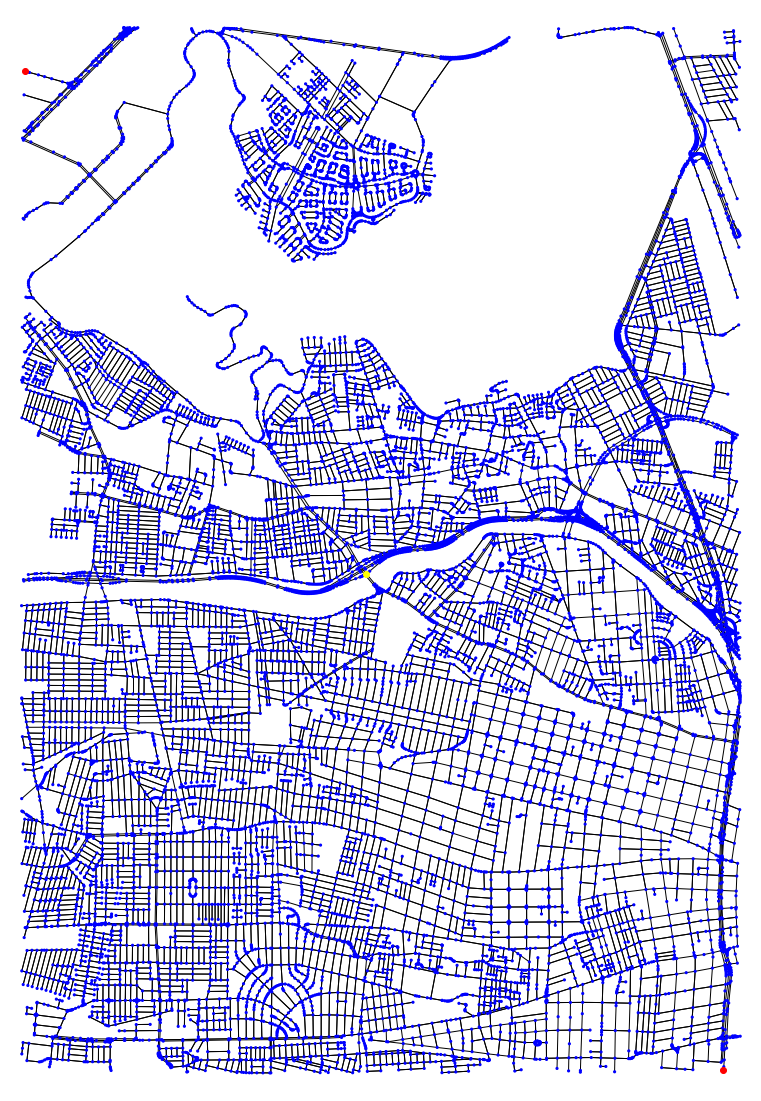

In [114]:
fig, ax = ox.plot_graph(net, figsize = (20,20), node_size = 10, bgcolor = 'w', node_color = 'blue', edge_color = 'black', show = False, close = False)

ax.scatter(orig_long, orig_lat, c='red')
ax.scatter(dest_long, dest_lat, c='red')

for i in id_clus:
    lat = nodes_net[nodes_net['osmid']==i]['y'].values[0]
    long = nodes_net[nodes_net['osmid']==i]['x'].values[0]
    ax.scatter(long, lat, c='yellow')

plt.show()

In [115]:
ox.speed.add_edge_speeds(net, hwy_speeds=None, fallback=None, precision=1)

In [ ]:
#resultado = dijkstra_tiempo(net, orig_node, dest_node, 6, 9, 0, set(), {}, {})
resultado = vecino_cercano(net, nodes_net, orig_node, dest_node, 6, 9, 0, 0, set(), {}, set(), {})
route = resultado[0][::-1]
total_time = resultado[1]

In [ ]:
print(route)

In [ ]:
total_time

In [ ]:
fig, ax = ox.plot_graph_route(net, route, node_size = 10, figsize=(20,20), bgcolor = 'w', node_color = 'blue', edge_color = 'black')

# Probando heurística

En primer lugar, se genera un subgrafo sociado al nodo de inicio:

In [ ]:
grafi = subgrafo(graph_s, 265690338, direccion_x, direccion_y, 2, 9)
# ox.plot_graph(grafi)

In [ ]:
nodes_s, edges_s = ox.graph_to_gdfs(grafi)

In [ ]:
# a = vecino_cercano(grafi, nodes_s,  265690338, 1475696760, 6, 9, 0, 0, set(), {}, set(), {})

In [ ]:
Imprimimos la ruta en el grafo:

In [ ]:
#predecessors = {1882519126: 1882519127, 1882519128: 1882519126, 990525992: 1882519128, 280839665: 990525992, 280841556: 280839665, 4431541904: 280841556, 280841163: 4431541904, 4431541896: 280841163, 280839907: 4431541896, 4431607727: 280839907, 4431607728: 4431607727, 4431607729: 4431607728, 280840782: 4431607729, 4431666678: 280840782, 4431666679: 4431666678, 4431666680: 4431666679, 280840815: 4431666680, 280840963: 280840815, 280840857: 280840963, 458570448: 280840857, 458570596: 458570448, 280841168: 458570596, 280841167: 280841168, 4431541898: 280841167, 280840205: 4431541898, 280840223: 280840205, 4431541897: 280840223, 280841164: 4431541897, 4431541905: 280841164, 8578447784: 4431541905, 8578447782: 8578447784, 8578447783: 8578447782, 458570637: 8578447783, 1795173214: 458570637, 8625017716: 1795173214, 1795173211: 8625017716, 5569835086: 1795173211, 4431703608: 5569835086, 280838628: 4431703608, 6548809030: 280838628, 280838626: 6548809030, 6055947268: 280838626, 5569845347: 6055947268, 5569835064: 5569845347, 3407196693: 5569835064, 3407196716: 3407196693, 2612785652: 3407196716, 4431703609: 2612785652, 592637501: 4431703609, 412208254: 592637501, 411229743: 412208254, 1989046190: 411229743, 411229746: 1989046190, 6546391161: 411229746, 3998083253: 6546391161, 411229747: 3998083253, 463042142: 411229747, 1842837626: 463042142, 4441349556: 1842837626, 605146258: 4441349556, 605146672: 605146258, 593681766: 605146672, 593723145: 593681766, 593723121: 593723145, 990511654: 593723121, 990511637: 990511654, 274495850: 990511637, 274496059: 274495850, 605146280: 274496059, 471275009: 605146280, 471275020: 471275009, 471275010: 471275020, 3878900659: 471275010, 2086694353: 3878900659, 307348811: 2086694353, 4453878865: 307348811, 264246387: 4453878865, 3733178225: 264246387, 370203605: 3733178225, 4422690365: 370203605, 6285254903: 4422690365, 264245833: 6285254903, 264246091: 264245833, 264246579: 264246091, 264245049: 264246579, 254346928: 264245049, 254346790: 254346928, 254343802: 254346790, 254343801: 254343802, 503445379: 254343801, 254346497: 503445379, 253281889: 254346497, 253281888: 253281889, 253281855: 253281888, 253281856: 253281855, 253281837: 253281856, 253281836: 253281837, 253281835: 253281836, 253411484: 253281835, 253282030: 253411484, 253281843: 253282030, 253282028: 253281843, 14095459: 253282028, 264248420: 14095459, 2212136922: 264248420, 253281999: 2212136922, 1873262215: 253281999, 254347313: 1873262215, 1584209737: 254347313, 253282327: 1584209737, 253282326: 253282327, 253282328: 253282326, 265690257: 253282328, 265690337: 265690257, 376263941: 265690337, 376263958: 376263941, 265690374: 376263958, 465140905: 265690374, 465140904: 465140905, 376264329: 465140904, 253282284: 376264329, 253282300: 253282284, 253282315: 253282300, 615098334: 253282315, 501544606: 615098334, 2389935311: 501544606, 6170121509: 2389935311, 6170121510: 6170121509, 265689527: 6170121510, 265689526: 265689527, 265689525: 265689526, 265689551: 265689525, 265689564: 265689551, 265689523: 265689564, 265689530: 265689523, 265689563: 265689530, 265689550: 265689563, 265689532: 265689550, 265689536: 265689532, 265689533: 265689536, 265689890: 265689533, 265689534: 265689890, 265689528: 265689534, 265689904: 265689528, 13882202: 265689904, 150930592: 13882202, 15092707: 150930592, 501544533: 15092707, 615098332: 501544533, 494719097: 615098332, 265690372: 494719097, 663097157: 265690372, 663097164: 663097157, 265690396: 663097164, 663097163: 265690396, 663097165: 663097163, 663097166: 663097165, 663097160: 663097166, 265690336: 663097160, 14528322: 265690336, 253282322: 14528322, 253282330: 253282322, 254347646: 253282330, 254347743: 254347646, 254347535: 254347743, 254347531: 254347535, 376283258: 254347531, 376283252: 376283258, 376283251: 376283252, 254347532: 376283251, 376283247: 254347532, 376283184: 376283247, 376282771: 376283184, 254347529: 376282771, 254347511: 254347529, 376282803: 254347511, 254347513: 376282803, 254347515: 254347513, 5780238387: 254347515, 663097155: 5780238387, 621912516: 663097155, 254347647: 621912516, 254347479: 254347647, 253282124: 254347479, 253282324: 253282124, 253282325: 253282324, 253282125: 253282325, 376280359: 253282125, 254347480: 376280359, 990658098: 254347480, 376268993: 990658098, 990658101: 376268993, 990658090: 990658101, 289348780: 990658090, 990658094: 289348780, 990658095: 990658094, 14528348: 990658095, 14528345: 14528348, 265506674: 14528345, 376271391: 265506674, 990658071: 376271391, 3878961593: 990658071, 990658081: 3878961593, 990658083: 990658081, 265983490: 990658083, 990658055: 265983490, 265983305: 990658055, 265984184: 265983305, 265984182: 265984184, 265984181: 265984182, 265984180: 265984181, 265984209: 265984180, 265984326: 265984209, 149899259: 265984326, 4394237410: 149899259, 265690428: 4394237410, 265690434: 265690428, 265690435: 265690434, 265690441: 265690435, 265690443: 265690441, 376265780: 265690443, 376265781: 376265780, 990658074: 376265781, 376265784: 990658074, 5780308194: 376265784, 513707166: 5780308194, 494719143: 513707166, 494719144: 494719143, 376267665: 494719144, 376286448: 376267665, 265690864: 376286448, 265690885: 265690864, 376267692: 265690885, 265690902: 376267692, 265981721: 265690902, 265981783: 265981721, 265980908: 265981783, 2352416452: 265980908, 265981793: 2352416452, 265981794: 265981793, 265981675: 265981794, 265981784: 265981675, 265981722: 265981784, 265981723: 265981722, 265690490: 265981723, 265690904: 265690490, 265690903: 265690904, 265690883: 265690903, 265690889: 265690883, 265690886: 265690889, 265690887: 265690886, 265690896: 265690887, 265690865: 265690896, 265690846: 265690865, 3481551032: 265690846, 494719116: 3481551032, 605143649: 494719116, 2911534488: 605143649, 2909706699: 2911534488, 265690852: 2909706699, 3481551020: 265690852, 7940185031: 3481551020, 471724547: 7940185031, 3481551040: 471724547, 3481551037: 3481551040, 3481551046: 3481551037, 265690611: 3481551046, 265690599: 265690611, 2909701575: 265690599, 265690553: 2909701575, 265690574: 265690553, 605143639: 265690574, 265690596: 605143639, 265690612: 265690596, 265690614: 265690612, 4424066550: 265690614, 265978420: 4424066550, 265978477: 265978420, 254841997: 265978477, 254842029: 254841997, 254842874: 254842029, 265978478: 254842874, 1390406804: 265978478, 1390406807: 1390406804, 254842642: 1390406807, 254841791: 254842642, 254842872: 254841791, 265978775: 254842872, 265978774: 265978775, 265978806: 265978774, 376269841: 265978806, 265978776: 376269841, 267803066: 265978776, 376269797: 267803066, 265990152: 376269797, 289353949: 265990152, 289353922: 289353949, 5008369956: 289353922, 254841673: 5008369956, 376278116: 254841673, 254347202: 376278116, 254347240: 254347202, 4401924803: 254347240, 4401924813: 4401924803, 663097797: 4401924813, 1570459916: 663097797, 253282127: 1570459916, 376280952: 253282127, 376280777: 376280952, 376280358: 376280777, 376280668: 376280358, 376280781: 376280668, 376280884: 376280781, 254347483: 376280884, 4455550755: 254347483, 4455550759: 4455550755, 289349815: 4455550759, 990614015: 289349815, 990614019: 990614015, 990614003: 990614019, 990614010: 990614003, 289348749: 990614010, 289352811: 289348749, 289353531: 289352811, 267803145: 289353531, 990613994: 267803145, 621918461: 990613994, 267803109: 621918461, 267802975: 267803109, 267803065: 267802975, 267802973: 267803065, 5755162789: 267802973, 267802974: 5755162789, 254842716: 267802974, 267803135: 254842716, 254842385: 267803135, 265978803: 254842385, 265978710: 265978803, 254842386: 265978710, 254842387: 254842386, 2909665191: 254842387, 254842388: 2909665191, 254842389: 254842388, 265978540: 254842389, 265978541: 265978540, 265690660: 265978541, 2909701543: 265690660, 265690667: 2909701543, 265690671: 265690667, 265690669: 265690671, 3481524425: 265690669, 5716230532: 3481524425, 14528457: 5716230532, 3481551026: 14528457, 3481459241: 3481551026, 265690847: 3481459241, 265690867: 265690847, 376286916: 265690867, 376287018: 376286916, 265690866: 376287018, 376287400: 265690866, 376287353: 376287400, 376287458: 376287353, 376287514: 376287458, 5780308192: 376287514, 253282288: 5780308192, 376287545: 253282288, 6219109399: 376287545, 6456689345: 6219109399, 6456689346: 6456689345, 376287469: 6456689346, 376287427: 376287469, 265690895: 376287427, 376287016: 265690895, 376286947: 376287016, 376286671: 376286947, 376287055: 376286671, 265690893: 376287055, 253282289: 265690893, 265690901: 253282289, 376285741: 265690901, 265981182: 376285741, 265981179: 265981182, 265981183: 265981179, 265690848: 265981183, 265981773: 265690848, 265981480: 265981773, 265981744: 265981480, 265981785: 265981744, 265981771: 265981785, 265981729: 265981771, 5779796622: 265981729, 265981478: 5779796622, 265980907: 265981478, 265981489: 265980907, 265981676: 265981489, 265981490: 265981676, 265980408: 265981490, 265981678: 265980408, 265980867: 265981678, 265980808: 265980867, 265984296: 265980808, 265984005: 265984296, 265983897: 265984005, 265980708: 265983897, 1980573543: 265980708, 265980705: 1980573543, 265980696: 265980705, 265980697: 265980696, 265980864: 265980697, 265980866: 265980864, 265981488: 265980866, 265981549: 265981488, 265981861: 265981549, 265980906: 265981861, 265980911: 265980906, 265981727: 265980911, 265981177: 265981727, 265981181: 265981177, 376285838: 265981181, 376285775: 376285838, 265981180: 376285775, 265981175: 265981180, 5727178257: 265981175, 6456689348: 5727178257, 605143615: 6456689348, 1040338400: 605143615, 265981573: 1040338400, 265981585: 265981573, 376285600: 265981585, 376285498: 376285600, 265981583: 376285498, 265981547: 265981583, 376285579: 265981547, 376285683: 376285579, 376285627: 376285683, 376285516: 376285627, 265981486: 376285516, 265980405: 265981486, 265980413: 265980405, 265980646: 265980413, 265980702: 265980646, 265980700: 265980702, 265980643: 265980700, 265690805: 265980643, 265980503: 265690805, 265980504: 265980503, 265980500: 265980504, 265980491: 265980500, 4397962591: 265980491, 265980410: 4397962591, 265980475: 265980410, 265980485: 265980475, 265980484: 265980485, 265980490: 265980484, 265980499: 265980490, 265980515: 265980499, 265980514: 265980515, 265980513: 265980514, 265690526: 265980513, 265983717: 265690526, 265983648: 265983717, 265983914: 265983648, 265983913: 265983914, 265983912: 265983913, 265983911: 265983912, 265984004: 265983911, 265984068: 265984004, 265983899: 265984068, 265983772: 265983899, 265983764: 265983772, 265983304: 265983764, 265983771: 265983304, 265983901: 265983771, 265983902: 265983901, 2914709766: 265983902, 605142915: 2914709766, 4394237428: 605142915, 3878961569: 4394237428, 473605180: 3878961569, 2737220982: 473605180, 376265232: 2737220982, 254347808: 376265232, 265690433: 254347808, 254347809: 265690433, 149899243: 254347809, 149899232: 149899243, 5732569492: 149899232, 4401722666: 5732569492, 4401722673: 4401722666, 149899140: 4401722673, 149899221: 149899140, 265690053: 149899221, 609297568: 265690053, 609297608: 609297568, 609297685: 609297608, 265689777: 609297685, 265689794: 265689777, 265689813: 265689794, 5706417281: 265689813, 265689562: 5706417281, 609297731: 265689562, 265689834: 609297731, 6307272096: 265689834, 265689888: 6307272096, 265689836: 265689888, 265689837: 265689836, 265689535: 265689837, 252819340: 265689535, 663085323: 252819340, 4455753371: 663085323, 3921015598: 4455753371, 2219964952: 3921015598, 6061170868: 2219964952, 250932052: 6061170868, 250932065: 250932052, 250932066: 250932065, 6047353958: 250932066, 250932068: 6047353958, 250931998: 250932068, 4401924823: 250931998, 250932324: 4401924823, 250932323: 250932324, 250932197: 250932323, 5362607476: 250932197, 250932321: 5362607476, 250931999: 250932321, 250932000: 250931999, 250932124: 250932000, 4469072066: 250932124, 250932142: 4469072066, 250932143: 250932142, 250932260: 250932143, 250932404: 250932260, 250932195: 250932404, 609297818: 250932195, 250932001: 609297818, 250931980: 250932001, 15379894: 250931980, 250932194: 15379894, 250932176: 250932194, 250932261: 250932176, 4401471316: 250932261, 609286380: 4401471316, 141061715: 609286380, 14528421: 141061715, 609286291: 14528421, 4470007483: 609286291, 609286378: 4470007483, 14528418: 609286378, 141061587: 14528418, 141061302: 141061587, 370168926: 141061302, 15092710: 370168926, 4455574694: 15092710, 4455574695: 4455574694, 14528425: 4455574695, 14528429: 14528425, 1900607656: 14528429, 5683084794: 1900607656, 6044687499: 5683084794, 3903499669: 6044687499, 5065323708: 3903499669, 3891166960: 5065323708, 4470028394: 3891166960, 3891166156: 4470028394, 3891166153: 3891166156, 3891166152: 3891166153, 1060423282: 3891166152, 265688323: 1060423282, 271981705: 265688323, 141061506: 271981705, 4401442555: 141061506, 141061460: 4401442555, 141061686: 141061460, 141061476: 141061686, 264248450: 141061476, 4470028390: 264248450, 1857514346: 4470028390, 13885196: 1857514346, 609286195: 13885196, 6044687500: 609286195, 141061381: 6044687500, 3301484072: 141061381, 3301484071: 3301484072, 3331853471: 3301484071, 13882310: 3331853471, 609293230: 13882310, 609293226: 609293230, 609293218: 609293226, 609293220: 609293218, 609293227: 609293220, 609293228: 609293227, 3409729158: 609293228, 5357794637: 3409729158, 6231484046: 5357794637, 609289233: 6231484046, 7671726653: 609289233, 13882309: 7671726653, 15092719: 13882309, 609286216: 15092719, 609286180: 609286216, 141061274: 609286180, 609286600: 141061274, 609286193: 609286600, 16107322: 609286193, 141061128: 16107322, 4434928984: 141061128, 4399529555: 4434928984, 605143971: 4399529555, 141061673: 605143971, 4765531800: 141061673, 14083350: 4765531800, 4401442531: 14083350, 253411478: 4401442531, 253411475: 253411478, 5268807077: 253411475, 6809871672: 5268807077, 253411557: 6809871672, 1060423266: 253411557, 612756370: 1060423266, 253411532: 612756370, 253282016: 253411532, 265688241: 253282016, 253281923: 265688241, 253411520: 253281923, 253411522: 253411520, 5419066246: 253411522, 253411525: 5419066246, 605145672: 253411525, 605145694: 605145672, 4401437046: 605145694, 4455192256: 4401437046, 254344723: 4455192256, 253411563: 254344723, 253411565: 253411563, 265688240: 253411565, 253411560: 265688240, 253411549: 253411560, 4448461357: 253411549, 4448461358: 4448461357, 253282032: 4448461358, 605144029: 253282032, 253282017: 605144029, 265688239: 253282017, 253282023: 265688239, 253411536: 253282023, 253411539: 253411536, 4455192257: 253411539, 4401437045: 4455192257, 253411470: 4401437045, 253411468: 253411470, 253281885: 253411468, 253411463: 253281885, 265688238: 253411463, 253282018: 265688238, 276078286: 253282018, 253282019: 276078286, 253282020: 253282019, 265688236: 253282020, 253281766: 265688236, 14760683: 253281766, 605145695: 14760683, 227926109: 605145695, 265688244: 227926109, 254344725: 265688244, 5917404325: 254344725, 369945287: 5917404325, 254346506: 369945287, 254346503: 254346506, 6014064393: 254346503, 605145696: 6014064393, 6812100771: 605145696, 5220596193: 6812100771, 254346560: 5220596193, 254346663: 254346560, 605145699: 254346663, 605145683: 605145699, 3458654252: 605145683, 253281817: 3458654252, 605145693: 253281817, 254346672: 605145693, 254346676: 254346672, 254346563: 254346676, 254346688: 254346563, 254346565: 254346688, 254346671: 254346565, 2041792921: 254346671, 254343740: 2041792921, 7671897194: 254343740, 254346870: 7671897194, 254346669: 254346870, 254346567: 254346669, 254346808: 254346567, 254346700: 254346808, 264247293: 254346700, 227925875: 264247293, 6701687242: 227925875, 605183922: 6701687242, 307081718: 605183922, 227925719: 307081718, 369945456: 227925719, 227925743: 369945456, 227925756: 227925743, 227925773: 227925756, 253281801: 227925773, 2970880237: 253281801, 3046679881: 2970880237, 2792557264: 3046679881, 253281792: 2792557264, 3577082421: 253281792, 4448453628: 3577082421, 253281790: 4448453628, 253281771: 253281790, 253281774: 253281771, 4452607424: 253281774, 265688234: 4452607424, 265688233: 265688234, 141061147: 265688233, 13877040: 141061147, 141061596: 13877040, 13877045: 141061596, 13877044: 13877045, 141061251: 13877044, 141061325: 141061251, 13877038: 141061325, 1223293566: 13877038, 6456689365: 1223293566, 1223293812: 6456689365, 5357935895: 1223293812, 5300250129: 5357935895, 476178061: 5300250129, 5916965028: 476178061, 369965187: 5916965028, 369961560: 369965187, 369965719: 369961560, 1597018428: 369965719, 1597018435: 1597018428, 3888644717: 1597018435, 4456599097: 3888644717, 5419366819: 4456599097, 253366596: 5419366819, 2025475946: 253366596, 609293242: 2025475946, 3887077722: 609293242, 2025475957: 3887077722, 369965811: 2025475957, 4130454005: 369965811, 609293245: 4130454005, 150924803: 609293245, 265689367: 150924803, 265689434: 265689367, 265689432: 265689434, 265689365: 265689432, 6405681798: 265689365, 149888132: 6405681798, 6061312661: 149888132, 6055341086: 6061312661, 1196458236: 6055341086, 2212136899: 1196458236, 265689781: 2212136899, 265689780: 265689781, 5721132020: 265689780, 5721132019: 5721132020, 5721132013: 5721132019, 5721132027: 5721132013, 265689779: 5721132027, 609297665: 265689779, 149899175: 609297665, 370171302: 149899175, 149899191: 370171302, 265689560: 149899191, 265689580: 265689560, 265689624: 265689580, 265689578: 265689624, 265690055: 265689578, 265689706: 265690055, 265689708: 265689706, 370171128: 265689708, 370171074: 370171128, 265689581: 370171074, 370171483: 265689581, 370171286: 370171483, 370171601: 370171286, 265689582: 370171601, 6314487795: 265689582, 150930591: 6314487795, 265689583: 150930591, 5706483194: 265689583, 5706483199: 5706483194, 150923725: 5706483199, 265689716: 150923725, 575459089: 265689716, 265689714: 575459089, 609297586: 265689714, 609297581: 609297586, 265689712: 609297581, 370202903: 265689712, 370202902: 370202903, 370202901: 370202902, 370202918: 370202901, 265689675: 370202918, 265689674: 265689675, 265689673: 265689674, 265689672: 265689673, 265689690: 265689672, 265689679: 265689690, 5917118236: 265689679, 615098302: 5917118236, 149899276: 615098302, 1899251391: 149899276, 1899251398: 1899251391, 1899251400: 1899251398, 1899251366: 1899251400, 627959265: 1899251366, 8015660146: 627959265, 8015660145: 8015660146, 1899255342: 8015660145, 627942912: 1899255342, 5796906760: 627942912, 276857631: 5796906760, 276857633: 276857631, 473605689: 276857633, 276858716: 473605689, 276858752: 276858716, 436325087: 276858752, 436325202: 436325087, 4394237436: 436325202, 605142905: 4394237436, 605142909: 605142905, 265983645: 605142909, 265983646: 265983645, 265983715: 265983646, 265983303: 265983715, 265983268: 265983303, 605142894: 265983268, 605142893: 605142894, 4394237438: 605142893, 276858731: 4394237438, 436325124: 276858731, 436325398: 436325124, 436325205: 436325398, 4394237440: 436325205, 276858710: 4394237440, 436325151: 276858710, 436325157: 436325151, 436325263: 436325157, 436325267: 436325263, 436325270: 436325267, 276858690: 436325270, 276858691: 276858690, 605142892: 276858691, 605142898: 605142892, 4394237439: 605142898, 265983302: 4394237439, 265983336: 265983302, 265980552: 265983336, 265980516: 265980552, 265980517: 265980516, 265980518: 265980517, 265980474: 265980518, 265980401: 265980474, 265980427: 265980401, 265980363: 265980427, 265980362: 265980363, 265690764: 265980362, 265690727: 265690764, 265690771: 265690727, 265980361: 265690771, 376288227: 265980361, 376288230: 376288227, 376288232: 376288230, 376288431: 376288232, 265690741: 376288431, 265690749: 265690741, 265987141: 265690749, 265987148: 265987141, 265987139: 265987148, 376289192: 265987139, 376289173: 376289192, 2903328862: 376289173, 265690723: 2903328862, 282085580: 265690723, 376289193: 282085580, 282085613: 376289193, 282085436: 282085613, 265690724: 282085436, 265690747: 265690724, 265690775: 265690747, 265690774: 265690775, 265690773: 265690774, 265690772: 265690773, 265690788: 265690772, 265690787: 265690788, 265690726: 265690787, 265690725: 265690726, 265690743: 265690725, 265690767: 265690743, 265690766: 265690767, 265690765: 265690766, 265690786: 265690765, 265690785: 265690786, 265690751: 265690785, 265690687: 265690751, 265690745: 265690687, 265690746: 265690745, 265690768: 265690746, 265690721: 265690768, 265690722: 265690721, 282085434: 265690722, 282085609: 282085434, 282085744: 282085609, 265690750: 282085744, 282085816: 265690750, 282085787: 282085816, 282085775: 282085787, 282093559: 282085775, 2024798547: 282093559, 282093345: 2024798547, 3481459242: 282093345, 3481499529: 3481459242, 282093410: 3481499529, 3481499536: 282093410, 3481499495: 3481499536, 265980092: 3481499495, 605143247: 265980092, 265980103: 605143247, 605143265: 265980103, 2024781663: 605143265, 4401272080: 2024781663, 2024781700: 4401272080, 2042620137: 2024781700, 2909808157: 2042620137, 2909808161: 2909808157, 2909803921: 2909808161, 2909798908: 2909803921, 2048772828: 2909798908, 5716230539: 2048772828, 2973117671: 5716230539, 2048772829: 2973117671, 4767959337: 2048772829, 2909705223: 4767959337, 2909705205: 2909705223, 2909705201: 2909705205, 265980015: 2909705201, 2042626782: 265980015, 2042626787: 2042626782, 1956795720: 2042626787, 265690674: 1956795720, 1388081232: 265690674, 1388081235: 1388081232, 772061742: 1388081235, 772062066: 772061742, 772061757: 772062066, 376273214: 772061757, 265987895: 376273214, 265978592: 265987895, 265987870: 265978592, 265979047: 265987870, 265979048: 265979047, 254842432: 265979048, 265979352: 254842432, 254842434: 265979352, 265978935: 254842434, 2909675159: 265978935, 254842333: 2909675159, 254842332: 254842333, 254842331: 254842332, 265978807: 254842331, 265979379: 265978807, 265979347: 265979379, 254842136: 265979347, 265979380: 254842136, 605143696: 265979380, 265979381: 605143696, 265979383: 265979381, 265979384: 265979383, 265979350: 265979384, 265979349: 265979350, 265979348: 265979349, 265978675: 265979348, 265978674: 265978675, 265978933: 265978674, 265979049: 265978933, 4399735755: 265979049, 4399735754: 4399735755, 265979050: 4399735754, 254842239: 265979050, 265979548: 254842239, 265979550: 265979548, 265979543: 265979550, 265979545: 265979543, 265978932: 265979545, 1841384083: 265978932, 265979142: 1841384083, 265979143: 265979142, 265978994: 265979143, 265978995: 265978994, 265978611: 265978995, 265987821: 265978611, 265987819: 265987821, 6405736127: 265987819, 2352282049: 6405736127, 376273617: 2352282049, 265987798: 376273617, 150930547: 265987798, 253295679: 150930547, 2986336937: 253295679, 2986337133: 2986336937, 1841384018: 2986337133, 1841384051: 1841384018, 1841384079: 1841384051, 1841384166: 1841384079, 265978963: 1841384166, 605143684: 265978963, 5920776354: 605143684, 605143679: 5920776354, 2986336738: 605143679, 2986336740: 2986336738, 265999698: 2986336740, 265988452: 265999698, 265988441: 265988452, 471262565: 265988441, 503519500: 471262565, 471262542: 503519500, 503519502: 471262542, 150930546: 503519502, 1809528556: 150930546, 2042555935: 1809528556, 4425394193: 2042555935, 4425394195: 4425394193, 2042555920: 4425394195, 1956795725: 2042555920, 1956795756: 1956795725, 2909251262: 1956795756, 2909251261: 2909251262, 3234763941: 2909251261, 2909251072: 3234763941, 4401300412: 2909251072, 265979816: 4401300412, 2908320703: 265979816, 265979877: 2908320703, 2024781652: 265979877, 4401272074: 2024781652, 2024781612: 4401272074, 2903371690: 2024781612, 2024781697: 2903371690, 2024781644: 2024781697, 265980042: 2024781644, 605143268: 265980042, 2024781614: 605143268, 605143260: 2024781614, 605143261: 605143260, 2024781638: 605143261, 2903336465: 2024781638, 2903331542: 2903336465, 605143241: 2903331542, 605143250: 605143241, 2024781676: 605143250, 2024781701: 2024781676, 3481499541: 2024781701, 14528464: 3481499541, 265980101: 14528464, 2024781628: 265980101, 265980046: 2024781628, 265980045: 265980046, 2024781668: 265980045, 2024781665: 2024781668, 2903359373: 2024781665, 2024781623: 2903359373, 2903361253: 2024781623, 2903362069: 2903361253, 2024781674: 2903362069, 7400295896: 2024781674, 2024781670: 7400295896, 2042555930: 2024781670, 2024781648: 2042555930, 2042574513: 2024781648, 2042555922: 2042574513, 2042555917: 2042555922, 1956795778: 2042555917, 2044172155: 1956795778, 2042535899: 2044172155, 627940183: 2042535899, 627940195: 627940183, 269846617: 627940195, 5721451729: 269846617, 512622816: 5721451729, 512622817: 512622816, 512622818: 512622817, 512622820: 512622818, 512622821: 512622820, 512622822: 512622821, 512622823: 512622822, 512622825: 512622823, 503519507: 512622825, 150926600: 503519507, 3481499503: 150926600, 3481499561: 3481499503, 605142846: 3481499561, 3481499497: 605142846, 3481499089: 3481499497, 3481499066: 3481499089, 3481499063: 3481499066, 3481499498: 3481499063, 3481499527: 3481499498, 3481499501: 3481499527, 3481499069: 3481499501, 3481499521: 3481499069, 605142852: 3481499521, 605142820: 605142852, 605142829: 605142820, 3481499091: 605142829, 3481499508: 3481499091, 3481499092: 3481499508, 605142836: 3481499092, 605142816: 605142836, 3481499502: 605142816, 376294571: 3481499502, 2024798551: 376294571, 282093561: 2024798551, 282085735: 282093561, 4399907740: 282085735, 282085703: 4399907740, 282085705: 282085703, 265690798: 282085705, 2024798554: 265690798, 2024798550: 2024798554, 2024798549: 2024798550, 2024798555: 2024798549, 265690799: 2024798555, 265690800: 265690799, 265690801: 265690800, 265690781: 265690801, 265980350: 265690781, 265980521: 265980350, 265980520: 265980521, 265980519: 265980520, 265980550: 265980519, 265980551: 265980550, 265982595: 265980551, 265983301: 265982595, 265983266: 265983301, 265983267: 265983266, 265982095: 265983267, 605142897: 265982095, 2051400948: 605142897, 436325207: 2051400948, 436325367: 436325207, 436325369: 436325367, 436325372: 436325369, 436325176: 436325372, 276858698: 436325176, 2051400950: 276858698, 436325210: 2051400950, 436325214: 436325210, 436325325: 436325214, 436325339: 436325325, 436325347: 436325339, 436325180: 436325347, 276858705: 436325180, 4473373006: 276858705, 605142711: 4473373006, 2051400949: 605142711, 605142706: 2051400949, 436325298: 605142706, 276858692: 436325298, 265984513: 276858692, 265983265: 265984513, 1980604585: 265983265, 1980604584: 1980604585, 265984515: 1980604584, 4398007270: 265984515, 282086321: 4398007270, 282086219: 282086321, 265980357: 282086219, 2911283548: 265980357, 2911283547: 2911283548, 282086100: 2911283547, 265690678: 282086100, 265980351: 265690678, 4473143548: 265980351, 4473143549: 4473143548, 2911185743: 4473143549, 282085949: 2911185743, 2911185741: 282085949, 282085918: 2911185741, 282085893: 282085918, 265980382: 282085893, 265980385: 265980382, 2903281894: 265980385, 3755605393: 2903281894, 2903277935: 3755605393, 2903277934: 2903277935, 3755605365: 2903277934, 282093605: 3755605365, 2024798545: 282093605, 265980342: 2024798545, 512622833: 265980342, 512622834: 512622833, 512622836: 512622834, 2903291827: 512622836, 2903291744: 2903291827, 282091713: 2903291744, 282091728: 282091713, 2903291745: 282091728, 2903291828: 2903291745, 512622837: 2903291828, 512622838: 512622837, 3733523325: 512622838, 282091126: 3733523325, 2914687811: 282091126, 2049701730: 2914687811, 2049701729: 2049701730, 2049701731: 2049701729, 282091714: 2049701731, 2903295248: 282091714, 605142737: 2903295248, 282091416: 605142737, 5721451318: 282091416, 2049746038: 5721451318, 2049701739: 2049746038, 2049701737: 2049701739, 5721451317: 2049701737, 2049701734: 5721451317, 2049701727: 2049701734, 282091652: 2049701727, 2049701738: 282091652, 2914687812: 2049701738, 282091125: 2914687812, 2914687750: 282091125, 512622839: 2914687750, 265984472: 512622839, 3748575034: 265984472, 282087097: 3748575034, 282087228: 282087097, 282087229: 282087228, 282086221: 282087229, 265980377: 282086221, 282085913: 265980377, 282085938: 282085913, 282086544: 282085938, 282086090: 282086544, 282086545: 282086090, 265980356: 282086545, 282086201: 265980356, 282086461: 282086201, 282086462: 282086461, 282086471: 282086462, 282086464: 282086471, 282086441: 282086464, 282086372: 282086441, 265984470: 282086372, 4398007263: 265984470, 5714430393: 4398007263, 265984469: 5714430393, 265980368: 265984469, 2973132053: 265980368, 605142768: 2973132053, 605142767: 605142768, 265690692: 605142767, 282090859: 265690692, 282090861: 282090859, 282091353: 282090861, 282090914: 282091353, 1980618080: 282090914, 1980618077: 1980618080, 265980383: 1980618077, 282087225: 265980383, 1980618079: 282087225, 1980619106: 1980618079, 282090925: 1980619106, 918111158: 282090925, 918111109: 918111158, 282090940: 918111109, 282090943: 282090940, 282091561: 282090943, 282091670: 282091561, 282091556: 282091670, 282091557: 282091556, 1856659210: 282091557, 282091052: 1856659210, 1980618120: 282091052, 282091508: 1980618120, 282091532: 282091508, 5714508000: 282091532, 282091418: 5714508000, 282091617: 282091418, 282091417: 282091617, 2049701732: 282091417, 2049701736: 2049701732, 2049701735: 2049701736, 2049701733: 2049701735, 605142716: 2049701733, 282087366: 605142716, 1980622903: 282087366, 2049701728: 1980622903, 282091420: 2049701728, 288989748: 282091420, 855668850: 288989748, 288989701: 855668850, 2049722050: 288989701, 1857514372: 2049722050, 5719116930: 1857514372, 2049722052: 5719116930, 2049743542: 2049722052, 288989702: 2049743542, 282092276: 288989702, 3748574724: 282092276, 3748574723: 3748574724, 2215421214: 3748574723, 5719116927: 2215421214, 918111190: 5719116927, 282092858: 918111190, 3481499090: 282092858, 855668808: 3481499090, 2049728666: 855668808, 855668892: 2049728666, 2903321732: 855668892, 282093062: 2903321732, 2049728664: 282093062, 282093112: 2049728664, 3751119853: 282093112, 282093096: 3751119853, 282093068: 282093096, 282092898: 282093068, 282093033: 282092898, 5721451727: 282093033, 282092730: 5721451727, 282092820: 282092730, 282092847: 282092820, 282092495: 282092847, 2888231802: 282092495, 2888194155: 2888231802, 282092807: 2888194155, 282092791: 282092807, 282092787: 282092791, 282098348: 282092787, 282092974: 282098348, 2888211893: 282092974, 282092910: 2888211893, 282092729: 282092910, 282092789: 282092729, 288989558: 282092789, 288989556: 288989558, 282091914: 288989556, 2888223468: 282091914, 282098323: 2888223468, 282098322: 282098323, 282098347: 282098322, 282098320: 282098347, 2044172157: 282098320, 288988979: 2044172157, 288988972: 288988979, 288988960: 288988972, 288988951: 288988960, 288989225: 288988951, 288989285: 288989225, 288989340: 288989285, 288989330: 288989340, 288989359: 288989330, 288989357: 288989359, 288989356: 288989357, 288989358: 288989356, 288989350: 288989358, 288989313: 288989350, 288989314: 288989313, 513707188: 288989314, 288989329: 513707188, 288989338: 288989329, 513707186: 288989338, 288989339: 513707186, 288989333: 288989339, 288989065: 288989333, 288989064: 288989065, 288989075: 288989064, 288989291: 288989075, 288989282: 288989291, 288989284: 288989282, 288989234: 288989284, 288989228: 288989234, 288988949: 288989228, 1841392267: 288988949, 288989052: 1841392267, 288989053: 288989052, 1841392253: 288989053, 1841392273: 1841392253, 288988957: 1841392273, 288989054: 288988957, 288988953: 288989054, 288989226: 288988953, 288989224: 288989226, 288988961: 288989224, 513707180: 288988961, 288988958: 513707180, 288988991: 288988958, 288988986: 288988991, 513707178: 288988986, 288988982: 513707178, 288989223: 288988982, 288988978: 288989223, 288988971: 288988978, 288988988: 288988971, 288989096: 288988988, 605139718: 288989096, 4403544939: 605139718, 4403544937: 4403544939, 288988970: 4403544937, 288988952: 288988970, 269846478: 288988952, 269846483: 269846478, 2888192096: 269846483, 2888195222: 2888192096, 2888195850: 2888195222, 2888195956: 2888195850, 2888187723: 2888195956, 605141807: 2888187723, 288989087: 605141807, 2888168608: 288989087, 2888185495: 2888168608, 2888185493: 2888185495, 1841392274: 2888185493, 4403544738: 1841392274, 479696182: 4403544738, 1221423942: 479696182, 1221420416: 1221423942, 718299047: 1221420416, 718299048: 718299047, 1857514349: 718299048, 4632344010: 1857514349, 1367969308: 4632344010, 1369099884: 1367969308, 1369099853: 1369099884, 265988643: 1369099853, 605143536: 265988643, 605143541: 605143536, 1841384009: 605143541, 1841384105: 1841384009, 265999693: 1841384105, 265999692: 265999693, 605143669: 265999692, 265988670: 605143669, 1841384036: 265988670, 265988680: 1841384036, 265988645: 265988680, 265988646: 265988645, 265999695: 265988646, 265999638: 265999695, 265988623: 265999638, 605142168: 265988623, 1841384191: 605142168, 265988678: 1841384191, 605142149: 265988678, 265988621: 605142149, 605142138: 265988621, 4632344011: 605142138, 4632344013: 4632344011, 265988755: 4632344013, 1841384069: 265988755, 1841384071: 1841384069, 605142177: 1841384071, 265988631: 605142177, 605142169: 265988631, 1841384143: 605142169, 265988220: 1841384143, 265988296: 265988220, 265988219: 265988296, 1841384114: 265988219, 265988093: 1841384114, 605142097: 265988093, 605141983: 605142097, 1841384117: 605141983, 265999707: 1841384117, 1841384046: 265999707, 253282562: 1841384046, 1841384031: 253282562, 1841384126: 1841384031, 1841384181: 1841384126, 1841384212: 1841384181, 1841384179: 1841384212, 1841384139: 1841384179, 265988146: 1841384139, 265988094: 265988146, 1841384107: 265988094, 605142047: 1841384107, 605142046: 605142047, 605142049: 605142046, 605142048: 605142049, 265988147: 605142048, 265988298: 265988147, 265988148: 265988298, 1841384021: 265988148, 605142051: 1841384021, 1841384033: 605142051, 605142052: 1841384033, 1841384010: 605142052, 265999691: 1841384010, 1841384111: 265999691, 4764330614: 1841384111, 265988096: 4764330614, 2887730644: 265988096, 1841384001: 2887730644, 2887731178: 1841384001, 1841384208: 2887731178, 1841384088: 1841384208, 253282565: 1841384088, 1867508093: 253282565, 503519515: 1867508093, 479696166: 503519515, 479696169: 479696166, 253282527: 479696169, 471266863: 253282527, 471266867: 471266863, 265999579: 471266867, 265999582: 265999579, 265999586: 265999582, 265999589: 265999586, 265999584: 265999589, 265999580: 265999584, 265999578: 265999580, 471266871: 265999578, 288989100: 471266871, 288989107: 288989100, 288989108: 288989107, 288989111: 288989108, 288989162: 288989111, 288989118: 288989162, 2041917155: 288989118, 288989116: 2041917155, 288989114: 288989116, 288989091: 288989114, 288989117: 288989091, 812309740: 288989117, 288989160: 812309740, 4403544929: 288989160, 288989164: 4403544929, 269846482: 288989164, 2887695137: 269846482, 812309682: 2887695137, 288990113: 812309682, 288990129: 288990113, 288990126: 288990129, 288990128: 288990126, 288990061: 288990128, 605139636: 288990061, 605139641: 605139636, 605139642: 605139641, 288990104: 605139642, 282094485: 288990104, 282094654: 282094485, 269846549: 282094654, 282098307: 269846549, 282098367: 282098307, 282098324: 282098367, 376293886: 282098324, 282098262: 376293886, 2888230274: 282098262, 2888230236: 2888230274, 282091916: 2888230236, 282097503: 282091916, 282091761: 282097503, 282097839: 282091761, 282097933: 282097839, 282093811: 282097933, 282097850: 282093811, 282098556: 282097850, 605139669: 282098556, 2888242101: 605139669, 282091825: 2888242101, 282092342: 282091825, 282094332: 282092342, 282094337: 282094332, 282093908: 282094337, 282094214: 282093908, 282093911: 282094214, 282094190: 282093911, 282093809: 282094190, 282094273: 282093809, 282094270: 282094273, 282093812: 282094270, 282094380: 282093812, 2888233916: 282094380, 2888234374: 2888233916, 5719116925: 2888234374, 2048409873: 5719116925, 282097552: 2048409873, 282097498: 282097552, 282097594: 282097498, 282097558: 282097594, 282097491: 282097558, 282097505: 282097491, 282097066: 282097505, 282094846: 282097066, 282097295: 282094846, 2888242112: 282097295, 4401517853: 2888242112, 282097311: 4401517853, 282091032: 282097311, 282097229: 282091032, 282088671: 282097229, 282094847: 282088671, 282088672: 282094847, 282094853: 282088672, 282097251: 282094853, 513707201: 282097251, 2888234373: 513707201, 2888233917: 2888234373, 282094587: 2888233917, 282093824: 282094587, 282094193: 282093824, 282094652: 282094193, 5721451307: 282094652, 282094583: 5721451307, 288989755: 282094583, 288989750: 288989755, 282091642: 288989750, 288989760: 282091642, 282091419: 288989760, 282091389: 282091419, 282091457: 282091389, 282091600: 282091457, 282091599: 282091600, 871514871: 282091599, 1980618122: 871514871, 1980618121: 1980618122, 282091054: 1980618121, 282091147: 282091054, 282091123: 282091147, 282091145: 282091123, 463129676: 282091145, 1814534802: 463129676}
path = a[0]
#4038709141
#path = []
#while pred != None:
 #   path.append(pred)
  #  pred=predecessors.get(pred,None)
# reverses the array, to display the path nicely
#readable = path[0]
path = path[::-1]

fig, ax = ox.plot_graph_route(grafi, path, show = False, close = False)
ax.scatter(direccion_y[list_id.index(265690338)], direccion_x[list_id.index(265690338)], c='yellow')
plt.show()

# Ruta mínima entre cada par

def subgrafoX(graph, src, dest, k):
    k_rutas = ox.distance.k_shortest_paths(graph, src, dest, k, weight='Tiempos de Viaje')
    lista_sets = []
    for counter, path in enumerate(k_rutas):
        lista_sets.append(set(path))
        if counter == k-1:
             break
    nodos = list(reduce(operator.or_, lista_sets))
    subgrafo = graph.subgraph(nodos)
    return subgrafo

**Actualizamos valores de arcos en el grafo de santiago, ahora se llamará G contiene velocidad con congestión**

In [ ]:
# G  = ox.utils_graph.graph_from_gdfs(nodes , edges , graph_attrs = None)

In [ ]:
# nodesG, edgesG = ox.graph_to_gdfs(G)

**Ahora podemos calcular la ruta mínima entre dos nodos, bajo cualquier atributo de arco**

#### Función que debe ir calculando los costos que difieren del tiempo

(56.83*(edges[lenght]/1000)) ---------------> Todos los arcos

(sumar + 21378) -----------------------------> Arcos salientes del depot

In [ ]:
def costos_agregados(graph, path):
    agregados = 0
    for n in range(len(path)-1):
        if path[len(path)-1] == 1882519127 and agregados == 0:
            agregados += 21378
        else:
            agregados += (56.83 * graph[path[n+1]][path[n]][0]['length'])/1000
    return (agregados)

##### Función que calcula la ruta mínima entre cada par de nodos

In [ ]:
# Calculate the shortest path dinamic time
def rutas_min_pares(G, list_id, mes, hora, minutos):
    caminos = []
    tiempo_inicial = time() 
    dic_rutas = {}
    #G = ox.utils_graph.graph_from_gdfs(nodes , edges , graph_attrs = None)
    visitados = set()
    subgrafos = {}
    for n1 in list_id:
        for n2 in list_id:
            if n1 != n2 and nx.has_path(G, n1,n2) and (n1 != 1882519127):
                print((n1, n2))
                if (n1, n2) not in visitados:
                    subg = subgrafo(G, n1, direccion_x, direccion_y, list_id.index(n1), list_id.index(n2))
                    subgrafos[(n2, n1)] = subg
                    visitados.add((n2, n1))
                else:
                    subg = subgrafos[(n2, n1)]
                
                nodes_subg, edges_subg = ox.graph_to_gdfs(subg)
                path, tiempo = vecino_cercano(subg, nodes_subg,  n1, n2, mes, hora, minutos, 0, set(), {}, set(), {})
                print('-------------------------------------------------------------------------------------------------------------------------------------------------')
                print('Encontro ruta min con Vecino Cercano del par de nodos', (n1, n2))
                print('-------------------------------------------------------------------------------------------------------------------------------------------------')
                costo_agregado = costos_agregados(subg, path)
                dic_rutas[(path[0], path[-1])] = [tiempo, costo_agregado]   
                caminos.append(path)
                print('***'*30)
                print('El camino entre el nodo', n1, 'y', n2, 'fue:', path)
                print('***'*30)
                
    tiempo_final = time() 
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    print ('El tiempo de ejecucion en minutos fue:', tiempo_ejecucion/60)
    return(dic_rutas, caminos)

In [ ]:
# ahora se calculan las rutas mínimas entre cada par
#dic_rutas = rutas_min_pares(graph_s, list_id, 6, 9, 0)
#dic_rutas_r = dic_rutas[0]

In [ ]:
caminos = dic_rutas[1]

In [ ]:
#print(dic_rutas)

Notamos que al ocupar el método 'haversine' se repite un nodo, debido a la cercania. De modo que dejaremos ese nodo con su id euclidiano.

**Revisamos todos los pares de nodos que efectivamente no tienen ruta entre sí**

In [ ]:
pares_sin_ruta = []
for n1 in list_id:
        for n2 in list_id:
            if n1 != n2 and nx.has_path(G, n1, n2)==False:
                pares_sin_ruta.append((n1, n2))
                
print('Los siguientes pares no tienen rutas entre sí:', pares_sin_ruta)

Hay 11 pares sin ruta entre sí

# -----------------------------------------------------------------------------------------------------

In [ ]:
"""# Necesitamos ahora, crear la estructura de grafo sin calles con los costos reales en los arcos entre cada par o-d
#Se importa la libreria networkx como nx

import networkx as nx

#Se importa la libreria pyplot de matplotlib como plt

import matplotlib.pyplot as plt

#Se crea un grafo asimétrico vacio

G = nx.DiGraph()

#Se crean los nodos:

#Se crean los nodos depot + clientes

G.add_nodes_from(list_id)

#Se crean los arcos entre los nodos
for a in dic_rutas:
    G.add_edge(a[0], a[1])
    G.edges[(a[0], a[1])]['Costo']= dic_rutas[a]
for n in G.nodes:
    if n == 267454352:
        G.nodes[n]['Depot'] = True
    else:
        G.nodes[n]['Depot'] = False
    
#Se dibuja el grafo

nx.draw(G, node_size = 12, font_size=1)

#Se muestra en pantalla

plt.show()"""



In [ ]:
"""G.nodes"""

In [ ]:
"""G.edges"""

In [ ]:
"""G.edges[(3485642555, 4765300244)]"""

In [ ]:
"""G.nodes[613890784]"""

# Creación de datos

In [ ]:
"""n = list_id.copy()# Clientes
camiones = [k for k in range (1,4)]
list_id.remove(267454352)
clientes = list_id
u={1: 5500, 2:5500, 3:5500}

import numpy as np
rnd=np.random
rnd.seed(0)

q={i:rnd.randint(500, 1000) for i in clientes}"""

In [ ]:
"""print(n)
print(clientes)
print(camiones)
print(u)
print(q)
print(list_id)"""

In [ ]:
"""import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.scatter(direccion_x,direccion_y,color="green")

for i in clientes:
       plt.annotate('$q_{%d}=%d$'%(i,q[i]),(direccion_x[clientes.index(i)],direccion_y[clientes.index(i)]))
    
plt.plot(direccion_x[0],direccion_y[0],color='red',marker='s')
plt.annotate('DC',(direccion_x[0],direccion_y[0]))

plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Gráfico de Nodos | VRP")

plt.show()"""



In [ ]:
"dic_rutas[(3485642555, 4765300244)]"

In [ ]:
""""arcos={i for i in dic_rutas.keys()}
# esto es literal dic_rutas
#distancia={(i,j):np.hypot(direccion_x[i]-direccion_x[j],direccion_y[i]-direccion_y[j]) 
          # for i in nodos for j in nodos if i!=j}
arcos"""

In [ ]:
"""plt.figure(figsize=(12,5))
plt.scatter(direccion_x,direccion_y,color="green")

for i in clientes:
    plt.annotate('$q_{%d}$'%(i),(direccion_x[clientes.index(i)],direccion_y[clientes.index(i)]))
    
plt.plot(direccion_x[0],direccion_y[0],color='red',marker='s')
plt.annotate('DC',(direccion_x[0],direccion_y[0]))

for i, j in arcos:
    plt.plot([direccion_x[n.index(i)],direccion_x[n.index(j)]],[direccion_y[n.index(i)],direccion_y[n.index(j)]],color="blue",alpha=0.3)
    #plt.annotate('C=%d'%dic_rutas[(i,j)], ((direccion_x[n.index(i)]+direccion_x[n.index(j)])/2, (direccion_y[n.index(i)]+direccion_y[n.index(j)])/2))
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Grafo completo, arcos entre todo par de nodos donde existe ruta| VRP")


plt.show()"""

Fuente: https://nbviewer.jupyter.org/github/CplexPython/Cplex-Python/blob/master/VRP/CVRP%20%7C%20Cplex%20%26%20Python%20.ipynb

# Utilizando Heurísticas para resolver VRP

In [ ]:
"""# Plot the shortest path
fig, ax = ox.plot_graph_route(G, route)"""